## Attention Only Regression Analysis

In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import *
from keras.models import Model
from keras import backend as K

Using TensorFlow backend.


In [2]:
import tensorflow as tf

In [3]:
import os
import numpy as np
import Bio
from Bio import SeqIO
import seaborn as sns
import pandas as pd
import Bio.motifs
%matplotlib inline
from sklearn import model_selection
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import scipy
sns.set_context('notebook')

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from signal_models import *

Using TensorFlow backend.


In [4]:
# if not os.path.isdir('/home/jtao/analysis/genomic_grammar_analysis/'):
#     os.mkdir('/home/jtao/analysis/genomic_grammar_analysis')
# os.chdir('/home/jtao/analysis/genomic_grammar_analysis')

## Functions

In [4]:
def convert_sequences_to_array(sequences):
    '''
    inputs: sequence of nucleotides represented as a string composed of A, C, G, T
    outputs: a list of numpy array representations of a sequence with:
             A = [1, 0, 0, 0]
             C = [0, 1, 0, 0]
             G = [0, 0, 1, 0]
             T = [0, 0, 0, 1]
             
    '''

    nucleotide_array_dict = {'A': [1, 0, 0, 0],
                             'C': [0, 1, 0, 0],
                             'G': [0, 0, 1, 0],
                             'T': [0, 0, 0, 1],
                             'N': [0.25,0.25,0.25,0.25]}

    sequence_array_list = []
    for seq in sequences:
        seq_array = []
        for nuc in seq:
            seq_array.append(nucleotide_array_dict[nuc])
        seq_array = np.array(seq_array, dtype=np.float16)
        sequence_array_list.append(seq_array)
    sequence_array_list = np.array(sequence_array_list,dtype=np.float16)
    return sequence_array_list

In [5]:
def quantile_normalize_df(df_input):
    df = df_input.copy()
    #compute rank
    dic = {}
    for col in df:
        dic.update({col : sorted(df[col])})
    sorted_df = pd.DataFrame(dic)
    rank = sorted_df.mean(axis = 1).tolist()
    #sort
    for col in df:
        t = np.searchsorted(np.sort(df[col]), df[col])
        df[col] = [rank[i] for i in t]
    return df

## Data Processing

In [21]:
!mergePeaks -d /home/jtao/analysis/genomic_grammar_analysis/atac_idr_peaks/c57bl6_veh_peaks.tsv /home/jtao/analysis/genomic_grammar_analysis/resized_peak_files/c57bl6_veh_peaks.tsv /home/jtao/analysis/genomic_grammar_analysis/resized_peak_files/c57bl6_kla-1h_peaks.tsv /home/jtao/analysis/genomic_grammar_analysis/resized_peak_files/c57bl6_il4-24h_peaks.tsv > merged_veh_kla_il4_peaks.tsv

	Max distance to merge: 100 bp
	Merging peaks... 
	Comparing ./resized_peak_files/c57bl6_veh_peaks.tsv (31553 total) and ./resized_peak_files/c57bl6_veh_peaks.tsv (31553 total)
	Comparing ./resized_peak_files/c57bl6_veh_peaks.tsv (31553 total) and ./resized_peak_files/c57bl6_kla-1h_peaks.tsv (21783 total)
	Comparing ./resized_peak_files/c57bl6_veh_peaks.tsv (31553 total) and ./resized_peak_files/c57bl6_il4-24h_peaks.tsv (33580 total)
	Comparing ./resized_peak_files/c57bl6_kla-1h_peaks.tsv (21783 total) and ./resized_peak_files/c57bl6_veh_peaks.tsv (31553 total)
	Comparing ./resized_peak_files/c57bl6_kla-1h_peaks.tsv (21783 total) and ./resized_peak_files/c57bl6_kla-1h_peaks.tsv (21783 total)
	Comparing ./resized_peak_files/c57bl6_kla-1h_peaks.tsv (21783 total) and ./resized_peak_files/c57bl6_il4-24h_peaks.tsv (33580 total)
	Comparing ./resized_peak_files/c57bl6_il4-24h_peaks.tsv (33580 total) and ./resized_peak_files/c57bl6_veh_peaks.tsv (31553 total)
	Comparing ./resized_peak_files/c5

In [98]:
merged_frame = pd.read_csv('/home/jtao/analysis/genomic_grammar_analysis/merged_veh_kla_il4_peaks.tsv', sep='\t')

# filter away peaks in unused chromsomes
filtered_frame = merged_frame[
             ~(merged_frame['chr'].str.contains('chrY')) & 
             ~(merged_frame['chr'].str.contains('chrM')) &
             ~(merged_frame['chr'].str.contains('random')) &
             ~(merged_frame['chr'].str.contains('Un'))]

# resize peaks
target_peak_size = 200
peakCenters = (filtered_frame['start'] + filtered_frame['end']) /2
int_peakCenters = np.ceil(peakCenters).astype(int)
new_starts = int_peakCenters - int(target_peak_size/2)
new_ends = int_peakCenters + int(target_peak_size/2)
filtered_frame['start'] = new_starts
filtered_frame['end'] = new_ends
filtered_frame.to_csv('/home/jtao/analysis/genomic_grammar_analysis/merged_veh_kla_il4_peaks_resized.tsv', sep='\t', index=False)

/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [99]:
%%bash
# extract sequences for analysis
pos2bed.pl /home/jtao/analysis/genomic_grammar_analysis/merged_veh_kla_il4_peaks_resized.tsv > /home/jtao/analysis/genomic_grammar_analysis/tmp
tail -n +2 /home/jtao/analysis/genomic_grammar_analysis/tmp > /home/jtao/analysis/genomic_grammar_analysis/merged_veh_kla_il4_peaks_resized.bed
rm tmp


	Converted 45369 peaks total



In [100]:
!/gpfs/data01/glasslab/home/jtao/code/tba/model_training/extract_sequences.py /home/jtao/analysis/genomic_grammar_analysis/merged_veh_kla_il4_peaks_resized.bed mm10 /home/jtao/analysis/genomic_grammar_analysis/merged_veh_kla_il4_peaks_resized.fasta

reading genome mm10


In [60]:
!annotatePeaks.pl merged_veh_kla_il4_peaks_resized.tsv mm10 -size 500 -d /home/jtao/analysis/genomic_grammar_analysis/tag_directories_enhancer_marks/*KLA* /home/jtao/analysis/genomic_grammar_analysis/tag_directories_enhancer_marks/*IL4* /home/jtao/analysis/genomic_grammar_analysis/tag_directories_enhancer_marks/*Veh*/ > /home/jtao/analysis/genomic_grammar_analysis/merged_veh_kla_il4_peaks_resized_annotated.tsv


	Peak file = merged_veh_kla_il4_peaks_resized.tsv
	Genome = mm10
	Organism = mouse
	Peak Region set to 500
	Tag Directories:
		./tag_directories_enhancer_marks/C57Bl6_BMDM_ChIP_H3K27Ac_KLA-1h_BC_16-04-15-rep1
		./tag_directories_enhancer_marks/C57Bl6_BMDM_ChIP_H3K27Ac_KLA-1h_BC_16-04-15-rep2
		./tag_directories_enhancer_marks/C57Bl6_BMDM_ChIP_H3K27ac_IL4-24h_MAH_l20171004
		./tag_directories_enhancer_marks/C57Bl6_BMDM_ChIP_H3K27ac_IL4-24h_MAH_l20171129
		./tag_directories_enhancer_marks/C57Bl6_BMDM_ChIP_H3K27ac_Veh_MAH_l20171004/
		./tag_directories_enhancer_marks/C57Bl6_BMDM_ChIP_H3K27ac_Veh_MAH_l20171121/
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 45369
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 45369
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0

In [104]:
# average tag counts from both replicates
h3k27ac_tag_frame = pd.read_csv('/home/jtao/analysis/genomic_grammar_analysis/merged_veh_kla_il4_peaks_resized_annotated.tsv', sep = '\t')

h3k27ac_tag_frame.index = h3k27ac_tag_frame['Chr'] + ':' + (h3k27ac_tag_frame['Start'] - 1 +150).astype(str) + '-' + \
    (h3k27ac_tag_frame['End'] -150).astype(str)

h3k27ac_tag_frame = h3k27ac_tag_frame[[x for x in h3k27ac_tag_frame.columns.values if 'Tag Count' in x]]
columns = [x.split(' ')[0].split('/')[2].lower() for x in h3k27ac_tag_frame.columns.values]
columns = [x.split('_')[4] + '_' + x.split('_')[6] for x in columns]
h3k27ac_tag_frame.columns = columns

h3k27ac_quantileTag_frame = quantile_normalize_df(h3k27ac_tag_frame)

treatments = sorted(set([x.split('_')[0] for x in columns]))

h3k27ac_meanTag_dict = {}
for t in treatments:
    h3k27ac_meanTag_dict[t] = h3k27ac_tag_frame[[x for x in h3k27ac_tag_frame.columns if t in x]].mean(axis=1).values
h3k27ac_meanTag_frame = pd.DataFrame(h3k27ac_meanTag_dict)
h3k27ac_meanTag_frame.index = h3k27ac_tag_frame.index.values

h3k27ac_quantileTag_dict = {}
for t in treatments:
    h3k27ac_quantileTag_dict[t] = h3k27ac_quantileTag_frame[[x for x in h3k27ac_quantileTag_frame.columns if t in x]].mean(axis=1).values
h3k27ac_meanQuantileTag_frame = pd.DataFrame(h3k27ac_quantileTag_dict)
h3k27ac_meanQuantileTag_frame.index = h3k27ac_quantileTag_frame.index.values

In [105]:
h3k27ac_tag_frame.mean()

kla-1h_16-04-15-rep1    24.504577
kla-1h_16-04-15-rep2    23.015659
il4-24h_l20171004       39.684403
il4-24h_l20171129       31.201952
veh_l20171004           62.341607
veh_l20171121           50.138751
dtype: float64

In [106]:
h3k27ac_tag_frame.var()

kla-1h_16-04-15-rep1    1406.089578
kla-1h_16-04-15-rep2    1539.370667
il4-24h_l20171004       4754.250734
il4-24h_l20171129       2776.557190
veh_l20171004           9467.284816
veh_l20171121           5291.817536
dtype: float64

In [107]:
h3k27ac_meanQuantileTag_frame.mean()

il4-24h    38.134231
kla-1h     38.048826
veh        38.259562
dtype: float64

In [108]:
h3k27ac_meanQuantileTag_frame.var()

il4-24h    3275.454161
kla-1h     3344.582430
veh        3225.955232
dtype: float64

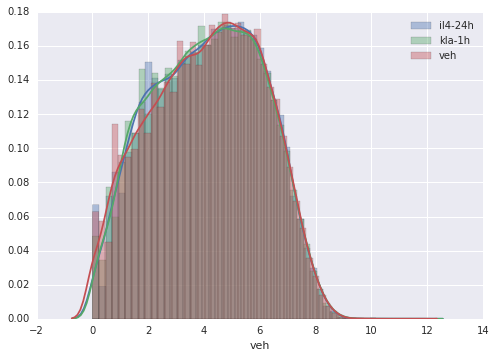

In [123]:
for treatment in h3k27ac_meanQuantileTag_frame:
    sns.distplot(np.log2(h3k27ac_meanQuantileTag_frame[treatment]+ 1) , label = treatment)
plt.legend()

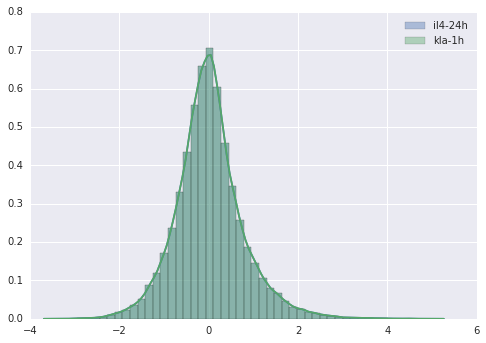

In [127]:
for treatment in h3k27ac_meanQuantileTag_frame:
    if not treatment == 'veh':
        sns.distplot(np.log2((h3k27ac_meanQuantileTag_frame['il4-24h'] + 1) / (h3k27ac_meanQuantileTag_frame['veh'] + 1)),
                     label = treatment)
plt.legend()



### Read in Sequence Data

In [109]:
len(set(seq_ids) - set(h3k27ac_meanQuantileTag_frame.index.values))

0

In [101]:
positive_seqRecords = list(SeqIO.parse('/home/jtao/analysis/genomic_grammar_analysis/merged_veh_kla_il4_peaks_resized.fasta', 'fasta'))
positive_seqRecords = [x for x in positive_seqRecords]
fasta_seq = [str(x.seq[:200]) for x in positive_seqRecords]

fasta_rc_seq = [str(x[:200].reverse_complement().seq) for x in positive_seqRecords ]

seq_ids = [x.name for x in positive_seqRecords]

sequence_arrays = convert_sequences_to_array(fasta_seq)
sequence_arrays = np.array(sequence_arrays)

sequence_rc_arrays = convert_sequences_to_array(fasta_rc_seq)
sequence_rc_arrays = np.array(sequence_rc_arrays)

index_seqArray_dict = dict(zip(seq_ids, zip(sequence_arrays, sequence_rc_arrays)))

In [128]:
h3k27ac_meanQuantileTag_frame.columns

Index(['il4-24h', 'kla-1h', 'veh'], dtype='object')

In [1439]:
pseudocount = 8
treatment = 'kla-1h'
# treatment = 'veh'
# treatment = 'il4-24h'
labels = np.log2((h3k27ac_meanQuantileTag_frame.loc[seq_ids,treatment] + pseudocount)/
                 (h3k27ac_meanQuantileTag_frame.loc[seq_ids,'veh'] + pseudocount)).values
# labels = ((h3k27ac_meanQuantileTag_frame.loc[seq_ids,treatment] + pseudocount)/
#          (h3k27ac_meanQuantileTag_frame.loc[seq_ids,'veh'] + pseudocount)).values
# labels = np.log2(h3k27ac_meanQuantileTag_frame.loc[seq_ids, treatment] + 1)
# labels = np.log2(h3k27ac_meanTag_frame.loc[seq_ids, treatment] + 1)
# labels = h3k27ac_meanTag_frame.loc[seq_ids, treatment]

x_train, x_test, x_rc_train, x_rc_test, y_train, y_test = model_selection.train_test_split(sequence_arrays, sequence_rc_arrays, labels, test_size=0.2)


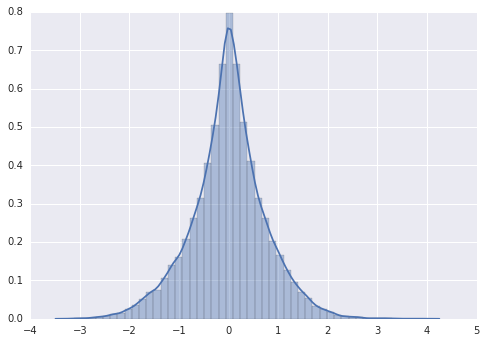

In [1440]:
sns.distplot(labels)

## Additive Attention

In [1547]:
del get_additiveAttention_regression_model

In [2]:
%load_ext autoreload


In [3]:
%autoreload 2

In [4]:
# os.chdir('/home/jtao/genomic_grammar/')

from signal_models import *

# os.chdir('/home/jtao/analysis/genomic_grammar_analysis/')

Using TensorFlow backend.


In [6]:
additiveProductAttention_regression_model = get_additiveAttention_regression_model(
    200,
    num_classes = 1,
    num_motifs=150, 
    motif_size=10,
    adjacent_bp_pool_size=10,
    attention_dim=10,
    attention_hops=1,
    num_dense_neurons=50,
    dropout_rate=0.1)

hi


In [1543]:
additiveProductAttention_regression_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_fwd (InputLayer)          (None, 200, 4)       0                                            
__________________________________________________________________________________________________
convolution_layer (Conv1D)      (None, 200, 150)     6150        input_fwd[0][0]                  
__________________________________________________________________________________________________
attention_tanh_layer (Dense)    (None, 200, 10)      1500        convolution_layer[0][0]          
__________________________________________________________________________________________________
attention_outer_layer (Dense)   (None, 200, 1)       10          attention_tanh_layer[0][0]       
__________________________________________________________________________________________________
attention_

In [1544]:
additiveProductAttention_regression_model.count_params()

7811

In [1546]:
additiveProductAttention_regression_model.fit([x_train, x_rc_train], y_train,
              batch_size=64,
              epochs=10,
              verbose=1,
              validation_data=([x_test, x_rc_test], y_test))



Train on 36295 samples, validate on 9074 samples
Epoch 1/10
36295/36295 [==============================] - 11s 316us/step - loss: 0.5300 - pearson_correlation: 0.3301 - val_loss: 0.5413 - val_pearson_correlation: 0.3121
Epoch 2/10
36295/36295 [==============================] - 11s 292us/step - loss: 0.5293 - pearson_correlation: 0.3365 - val_loss: 0.5531 - val_pearson_correlation: 0.3218
Epoch 3/10
36295/36295 [==============================] - 11s 297us/step - loss: 0.5274 - pearson_correlation: 0.3435 - val_loss: 0.5348 - val_pearson_correlation: 0.3180
Epoch 4/10
36295/36295 [==============================] - 11s 294us/step - loss: 0.5263 - pearson_correlation: 0.3489 - val_loss: 0.5405 - val_pearson_correlation: 0.3249
Epoch 5/10
36295/36295 [==============================] - 11s 293us/step - loss: 0.5249 - pearson_correlation: 0.3539 - val_loss: 0.5433 - val_pearson_correlation: 0.3257
Epoch 6/10
36295/36295 [==============================] - 11s 293us/step - loss: 0.5240 - pearso

In [1450]:
predictions = additiveProductAttention_regression_model.predict([sequence_arrays, sequence_rc_arrays])

print(scipy.stats.pearsonr(labels, predictions.flatten()))
print(scipy.stats.pearsonr(np.log2(labels+1), np.log2(predictions.flatten()+1)))
print(scipy.stats.pearsonr(np.exp2(labels), np.exp2(predictions.flatten())))





(0.3527602386063607, 0.0)
(nan, 1.0)
(0.31252842449641977, 0.0)


/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log2
  after removing the cwd from sys.path.


/home/jtao/software/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/jtao/software/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


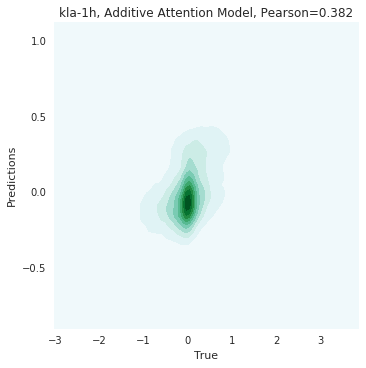

In [1398]:
pearson, _ = scipy.stats.pearsonr(labels, predictions.flatten())
sns.kdeplot(labels, predictions.flatten(), shade = True)
ax = plt.gca()
ax.set_aspect(ax.get_xlim()[1]/ax.get_ylim()[1])
plt.xlabel('True')
plt.ylabel('Predictions')
plt.title(treatment + ', Additive Attention Model, Pearson='+str(np.round(pearson,3)))

## Dot Product Attention

In [12]:
dotProductAttention_regression_model = get_dotProductAttention_regression_model(200,
    num_classes = 1,
    num_motifs=150, 
    motif_size=10,
    adjacent_bp_pool_size=10,
    num_dense_neurons=1,
    dropout_rate=0.1)

In [1536]:
# SVG(model_to_dot(dotProductAttention_model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [1538]:
dotProductAttention_regression_model.count_params()

9601

In [1539]:
dotProductAttention_regression_model.fit([x_train, x_rc_train], y_train,
              batch_size=64,
              epochs=10,
              verbose=1,
              validation_data=([x_test, x_rc_test], y_test))



Train on 36295 samples, validate on 9074 samples
Epoch 1/10
36295/36295 [==============================] - 20s 562us/step - loss: 0.5372 - pearson_correlation: 0.2475 - val_loss: 0.5282 - val_pearson_correlation: 0.2743
Epoch 2/10
36295/36295 [==============================] - 10s 271us/step - loss: 0.5261 - pearson_correlation: 0.2824 - val_loss: 0.5231 - val_pearson_correlation: 0.3042
Epoch 3/10
36295/36295 [==============================] - 10s 269us/step - loss: 0.5182 - pearson_correlation: 0.3086 - val_loss: 0.5361 - val_pearson_correlation: 0.3255
Epoch 4/10
36295/36295 [==============================] - 10s 263us/step - loss: 0.5115 - pearson_correlation: 0.3295 - val_loss: 0.5195 - val_pearson_correlation: 0.3314
Epoch 5/10
36295/36295 [==============================] - 10s 268us/step - loss: 0.5058 - pearson_correlation: 0.3454 - val_loss: 0.5402 - val_pearson_correlation: 0.3387
Epoch 6/10
36295/36295 [==============================] - 10s 269us/step - loss: 0.4991 - pearso

In [1540]:
predictions = dotProductAttention_regression_model.predict([sequence_arrays, sequence_rc_arrays])


print(scipy.stats.pearsonr(labels, predictions.flatten()))
print(scipy.stats.pearsonr(np.log2(labels+1), np.log2(predictions.flatten()+1)))
print(scipy.stats.pearsonr(np.exp2(labels), np.exp2(predictions.flatten())))





(0.40847450035783517, 0.0)
(nan, 1.0)
(0.37890021651000444, 0.0)


/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log2
  """


/home/jtao/software/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/jtao/software/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


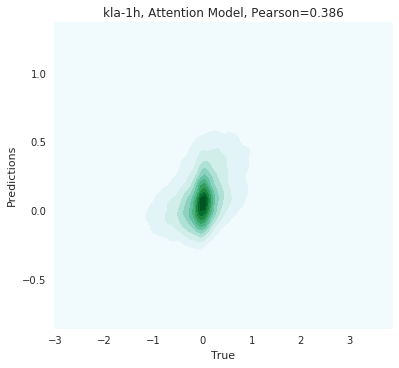

In [1410]:

pearson, _ = scipy.stats.pearsonr(labels, predictions.flatten())
sns.kdeplot(labels, predictions.flatten(), shade = True)
ax = plt.gca()
ax.set_aspect(ax.get_xlim()[1]/ax.get_ylim()[1])
plt.xlabel('True')
plt.ylabel('Predictions')
plt.title(treatment + ', Attention Model, Pearson='+str(np.round(pearson,3)))

## Compare against Convolution

In [1474]:
convolution_regression_model = get_convolution_regression_model(200,
    num_classes = 1,
    seq_size=150,
    num_motifs=100, 
    motif_size=24,
    num_dense_neurons=50,
    dropout_rate=0.75)

In [1475]:
convolution_regression_model.count_params()

14801

In [1476]:
convolution_regression_model.fit([x_train, x_rc_train], y_train,
      batch_size=64,
      epochs=10,
      verbose=1,
      validation_data=([x_test, x_rc_test], y_test))

Train on 36295 samples, validate on 9074 samples
Epoch 1/10
36295/36295 [==============================] - 21s 568us/step - loss: 0.5625 - pearson_correlation: 0.1308 - val_loss: 0.5415 - val_pearson_correlation: 0.2577
Epoch 2/10
36295/36295 [==============================] - 12s 324us/step - loss: 0.5484 - pearson_correlation: 0.1888 - val_loss: 0.5385 - val_pearson_correlation: 0.2656
Epoch 3/10
36295/36295 [==============================] - 12s 323us/step - loss: 0.5434 - pearson_correlation: 0.2124 - val_loss: 0.5372 - val_pearson_correlation: 0.2770
Epoch 4/10
36295/36295 [==============================] - 12s 322us/step - loss: 0.5386 - pearson_correlation: 0.2325 - val_loss: 0.5318 - val_pearson_correlation: 0.2933
Epoch 5/10
36295/36295 [==============================] - 12s 322us/step - loss: 0.5365 - pearson_correlation: 0.2397 - val_loss: 0.5292 - val_pearson_correlation: 0.2977
Epoch 6/10
36295/36295 [==============================] - 12s 325us/step - loss: 0.5287 - pearso

In [1464]:
predictions = convolution_regression_model.predict([sequence_arrays, sequence_rc_arrays])

print(scipy.stats.pearsonr(labels, predictions.flatten()))
print(scipy.stats.pearsonr(np.log2(labels+1), np.log2(predictions.flatten()+1)))
print(scipy.stats.pearsonr(np.exp2(labels), np.exp2(predictions.flatten())))

(0.4287576850305929, 0.0)
(nan, 1.0)
(0.4173367445545139, 0.0)


/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log2
  after removing the cwd from sys.path.


/home/jtao/software/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/jtao/software/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


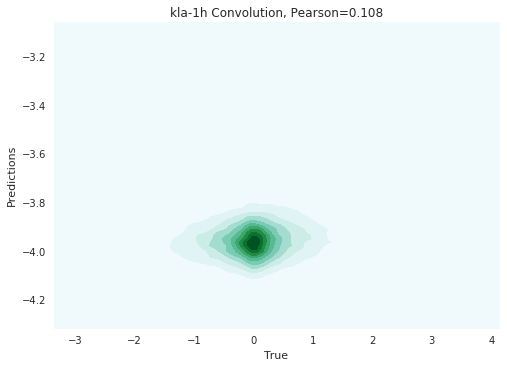

In [1373]:
pearson, _ = scipy.stats.pearsonr(labels, predictions.flatten())
sns.kdeplot(labels, predictions.flatten(), shade = True)
# ax = plt.gca()
# ax.set_aspect(ax.get_xlim()[1]/ax.get_ylim()[1])
plt.xlabel('True')
plt.ylabel('Predictions')
plt.title(treatment + ' Convolution, Pearson='+str(np.round(pearson,3)))